In [ ]:
# Checking to see if GPU drive is active
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 25 16:04:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Checking to see if GPU drive is active
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
# If running in google colab:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [74]:
# Download en_core_web_lg for google colab
# !python -m spacy download en_core_web_lg

In [75]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import regex as re
# import unicodedata

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, pairwise_distances

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# KNN used to help determine epsilon value for DBSCAN
from sklearn.neighbors import NearestNeighbors


# import spacy
# import en_core_web_lg
# from spacy.lang.en import English
# from spacy.lang.en.stop_words import STOP_WORDS

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [76]:
# # Loading the large (sm) spaCy English model, pre-trained on web text data
# # In order to use vectorization, you must use the large pipeline package
# # https://spacy.io/usage/spacy-101
# '''
# "To make them compact and fast, spaCy’s small pipeline packages (all packages that end in sm) 
# don’t ship with word vectors, and only include context-sensitive tensors... 
# So in order to use real word vectors, you need to download a larger pipeline package."
# '''
# nlp = en_core_web_lg.load()

# # max length must be increased due to large size of each document
# nlp.max_length = 10000000 # or higher

In [77]:
# # Importing the finalized concatinated dataframe
# # Use this line if running locally
# data = pd.read_csv('../data/tweet_vectors.csv')

# If running in google colab, use this import line:
# Change to file location if necessary
# data = pd.read_csv('/content/drive/MyDrive/Python/tweet_vectors_1.csv')

data1 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_1.json')
data2 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_2.json')
data3 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_3.json')
data4 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_4.json')


In [78]:
# data1.head()

In [79]:
data = pd.concat([data1, data2, data3, data4], axis=0, sort=False)

# data = data.drop_duplicates()

In [80]:
# keeping only certain columns that will be used
columns_keep =['screen_name','state','position','name','party','tweet_count','text_concat_clean','liststring','vectors']

data = data[columns_keep]

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 129
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   screen_name        521 non-null    object
 1   state              521 non-null    object
 2   position           521 non-null    object
 3   name               521 non-null    object
 4   party              521 non-null    object
 5   tweet_count        521 non-null    int64 
 6   text_concat_clean  521 non-null    object
 7   liststring         521 non-null    object
 8   vectors            521 non-null    object
dtypes: int64(1), object(8)
memory usage: 40.7+ KB


In [82]:
data.shape

(521, 9)

In [83]:
# Create X
X = data['vectors']
X = np.matrix(X.tolist())

# Applying the Standard Scaler to word vectors
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Applying PCA to word vectors
# choosing n components
# https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X)

# Applying standard scaler, then applying PCA to word vectors
pca_sc = PCA(n_components = 0.95)
X_pca_sc = pca_sc.fit_transform(X_sc)


In [84]:
def find_scores_k(X_choice):
    # looking at multiple silhouette scores

  # set up empty list to store scores
  scores_sil = []
  scores_ine = []

  for k in range(2, 10):
      # instantiate model
      km = KMeans(n_clusters=k, random_state=516)

      # fit the model
      km.fit(X_choice)

      # Get silhouette score for each k
      sil_score = silhouette_score(X_choice, km.labels_)
      scores_sil.append([k, sil_score])
      # Get inertia score for each k
      scores_ine.append([k, km.inertia_])

  # save as a df for viewing
  scores_df1 = pd.DataFrame(scores_sil, columns = ['k', 'silhouette'])
  scores_df2 = pd.DataFrame(scores_ine, columns = ['k', 'inertia'])

  scores_df = pd.merge(scores_df1, scores_df2, on = "k", how = "inner")

  # looking at silhouette scores
  return scores_df

In [85]:
find_scores_k(X)

,k,silhouette,inertia
0,2,0.192319,4.949956
1,3,0.186348,4.438667
2,4,0.137206,4.017377
3,5,0.117940,3.772031
4,6,0.106993,3.584653
5,7,0.109375,3.452560
6,8,0.093971,3.349322
7,9,0.090033,3.256116


In [86]:
find_scores_k(X_sc)

,k,silhouette,inertia
0,2,0.140577,133972.668919
1,3,0.143837,122126.407703
2,4,0.100861,113294.138143
3,5,0.095934,108628.741332
4,6,0.085871,105208.427763
5,7,0.088974,101936.236896
6,8,0.087550,99420.077642
7,9,0.087476,97644.226825


In [87]:
find_scores_k(X_pca)

,k,silhouette,inertia
0,2,0.203532,4.643701
1,3,0.198798,4.144673
2,4,0.153420,3.709719
3,5,0.127897,3.464285
4,6,0.117709,3.276448
5,7,0.105424,3.139400
6,8,0.097064,3.046722
7,9,0.096997,2.952287


In [88]:
find_scores_k(X_pca_sc)

,k,silhouette,inertia
0,2,0.149051,126171.716677
1,3,0.153355,113974.732488
2,4,0.109155,105503.931360
3,5,0.101543,100839.654645
4,6,0.094325,97372.278178
5,7,0.095139,94229.414222
6,8,0.085369,91890.170868
7,9,0.087677,89608.531807


In [89]:
# plotting the silhouette scores across k's

def plot_sil_score(X_choice):
  
    # looking at multiple silhouette scores

  # set up empty list to store scores
  scores_sil = []

  for k in range(2, 10):
      # instantiate model
      km = KMeans(n_clusters=k, random_state=516)

      # fit the model
      km.fit(X_choice)

      # Get silhouette score for each k
      sil_score = silhouette_score(X_choice, km.labels_)
      scores_sil.append([k, sil_score])

  # save as a df for viewing
  scores_df = pd.DataFrame(scores_sil, columns = ['k', 'silhouette'])

  plt.figure(figsize=(12,9))

  plt.plot(scores_df['k'], scores_df['silhouette'])

  plt.title(f'Silhouette Scores over K')

  plt.show()

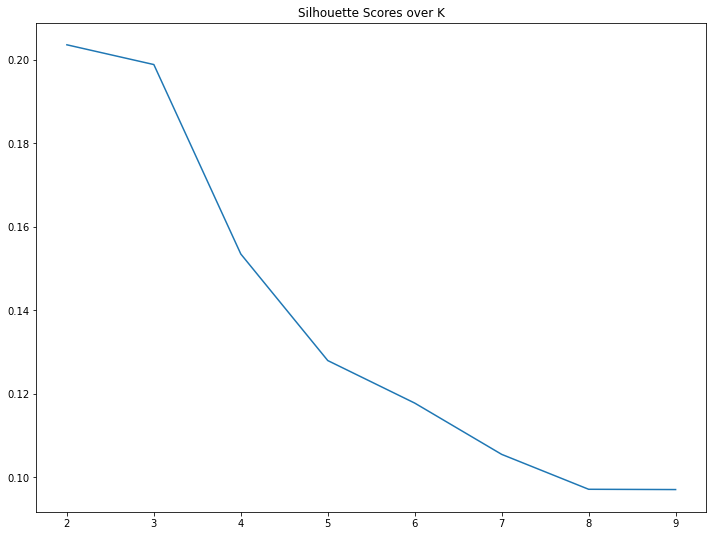

In [90]:
plot_sil_score(X_pca)

In [91]:
# plotting the inertia scores across k's
# Using the 'elbow' method to help find a good k
# https://medium.com/@cmukesh8688/k-means-clustering-in-machine-learning-252130c85e23

def plot_inertia_score(X_choice):
  
    # looking at multiple silhouette scores

  # set up empty list to store scores
  scores_ine = []

  for k in range(2, 10):
      # instantiate model
      km = KMeans(n_clusters=k, random_state=516)

      # fit the model
      km.fit(X_choice)

      # Get inertia score for each k
      scores_ine.append([k, km.inertia_])

  # save as a df for viewing
  scores_df = pd.DataFrame(scores_ine, columns = ['k', 'inertia'])

  plt.figure(figsize=(12,9))

  plt.plot(scores_df['k'], scores_df['inertia'])

  plt.title(f'Inertia Scores over K')

  plt.show()

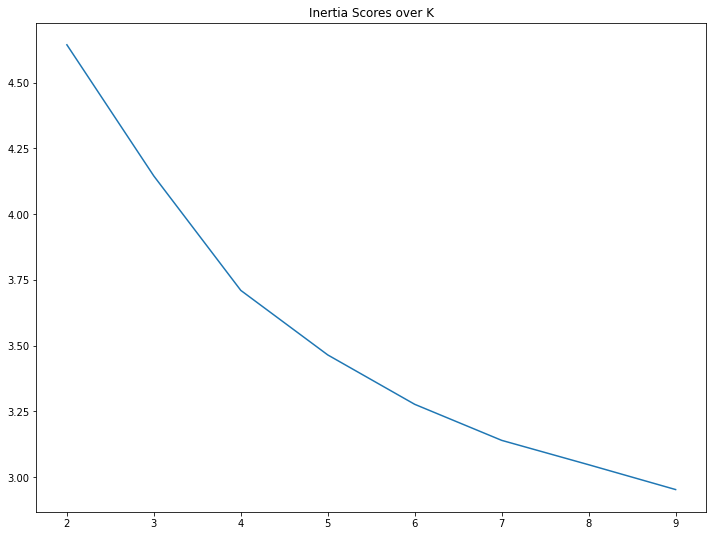

In [92]:
plot_inertia_score(X_pca)

In [93]:
# from sklearn.cluster import KMeans
def plot_k_clusters(k, X_choice):
  km = KMeans(n_clusters=k, random_state=516)
  km.fit(X_choice)
  km_means = km.predict(X_choice)

  plt.figure(figsize=(12,8))

  plt.scatter([X_choice[:, 0]], [X_choice[:, 1]], c=km_means, s=25, cmap='crest')

  centers = km.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)

  plt.title(f'Clusters and Centroids:\n k = {k}', size=20)
  plt.show()

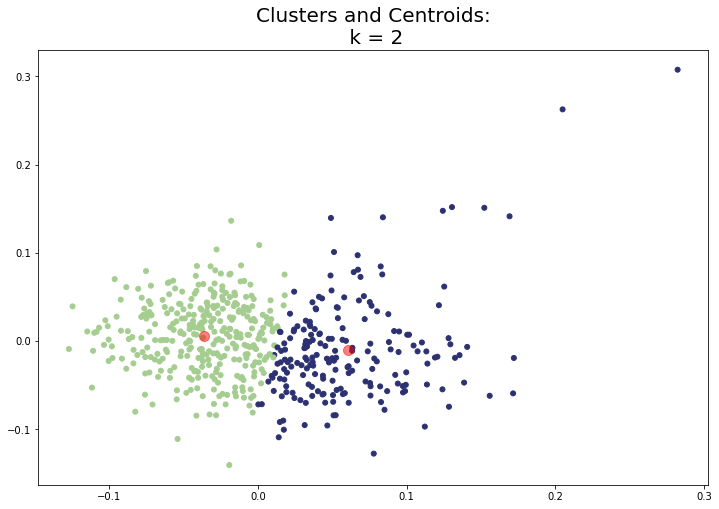

In [94]:
plot_k_clusters(2, X_pca)

In [95]:
# Based on above information, fitting with model with best inertia score
# to get labels

km = KMeans(n_clusters = 2, random_state=516)

km.fit(X_pca)


print(set(km.labels_))

print(silhouette_score(X_pca, km.labels_))

print('--------------------')

data['km_label'] = km.labels_

print(data['km_label'].value_counts())

print('--------------------')

# print(km.cluster_centers_)

# adding km labels back on the dataframe
data['km_label'] = km.labels_

{0, 1}
0.2035320851515295
--------------------
0    326
1    195
Name: km_label, dtype: int64
--------------------


In [96]:
# Function Using KNN to help find a good epsilon score
# to be used with DBSCAN
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

def find_epsilon(X_choice, knn_n):

  k_neighbors = NearestNeighbors(n_neighbors=knn_n)

  k_nbrs = k_neighbors.fit(X_choice)

  distances, indices = k_nbrs.kneighbors(X_choice)

  distances = np.sort(distances, axis=0)

  distances = distances[:,1]

  plt.figure(figsize=(12,8))

  plt.plot(distances)

  plt.title(f'Using KNN to Help Find Epsilon Score\n knn: {knn_n}', size=20)

  plt.show()

In [97]:
# Function to find silhouette score for DBSCAN using the epsilon
# fount from the graphs (elbow test)
# min_samples is set to natural log of number of points to be clustered
# HELP: https://askdatascience.com/646/dbscan-algorithm-how-should-choose-optimal-minimum-points
# HELP: https://moonbooks.org/Articles/How-to-calculate-the-natural-logarithm-in-python-/

def find_scores_db(X_choice, eps_value):

  dbscan = DBSCAN(eps=eps_value, min_samples=np.log(len(data))) #change the epsilon

  dbscan.fit(X_choice)

  print(set(dbscan.labels_))

  print(silhouette_score(X, dbscan.labels_))

  print('--------------------')

  data['dbscan_label'] = dbscan.labels_

  print(data['dbscan_label'].value_counts())

  print('--------------------')


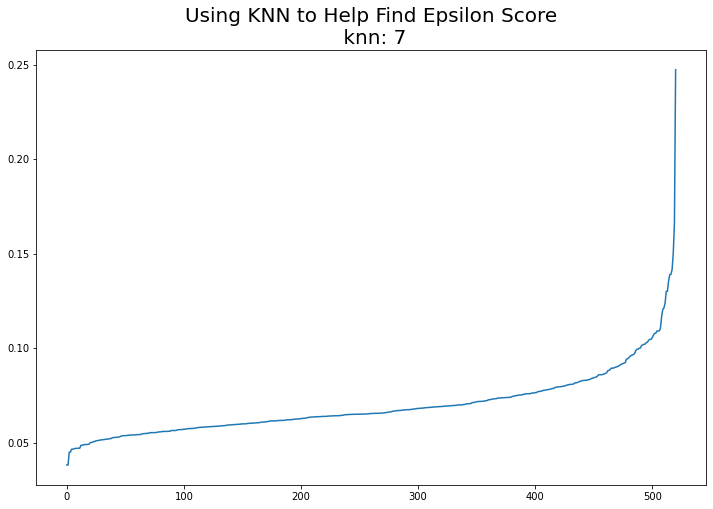

In [98]:
find_epsilon(X, 7)

In [99]:
find_scores_db(X, 0.11)

{0, -1}
0.4185483131384291
--------------------
 0    507
-1     14
Name: dbscan_label, dtype: int64
--------------------


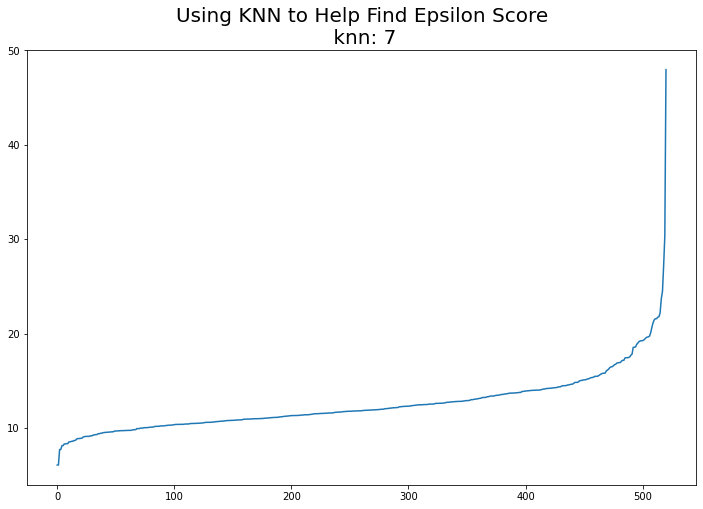

In [100]:
find_epsilon(X_sc, 7)

In [101]:
find_scores_db(X_sc, 20)

{0, -1}
0.4072014256621387
--------------------
 0    507
-1     14
Name: dbscan_label, dtype: int64
--------------------


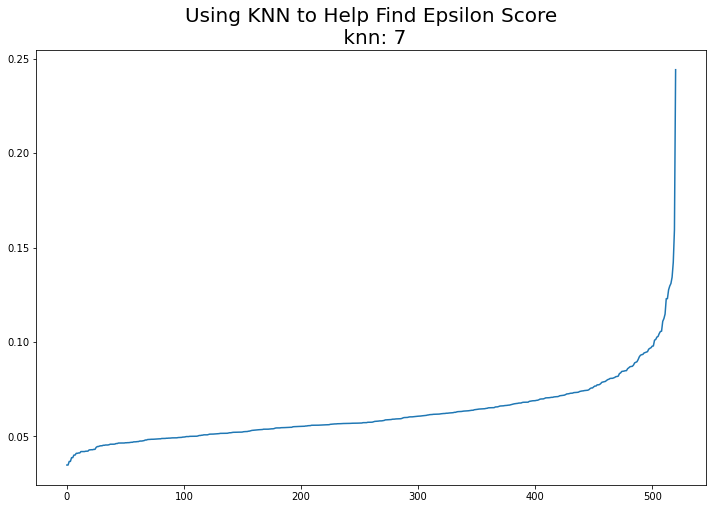

In [102]:
find_epsilon(X_pca, 7)

In [103]:
find_scores_db(X_pca, 0.11)

{0, -1}
0.4409507451517142
--------------------
 0    509
-1     12
Name: dbscan_label, dtype: int64
--------------------


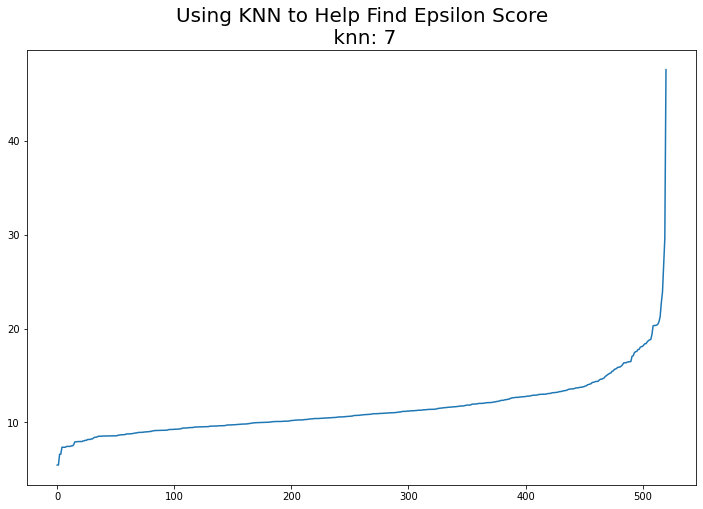

In [104]:
find_epsilon(X_pca_sc, 7)

In [105]:
find_scores_db(X_pca_sc, 20)

{0, -1}
0.4350753324361217
--------------------
 0    509
-1     12
Name: dbscan_label, dtype: int64
--------------------


##CVEC and TF-IDF

In [106]:
# Create X
X_ = data['liststring']
# X_ = np.matrix(X_.tolist())

In [107]:
cvec = CountVectorizer(max_features = 250, ngram_range = (1, 1))


# tvec = TfidfVectorizer(max_df = .80, min_df = 10, max_features = 200, ngram_range = (1, 2))
tvec = TfidfVectorizer(max_features = 200, ngram_range = (1, 1))



In [108]:
X_c = pd.DataFrame(cvec.fit_transform(X_).toarray(), columns = cvec.get_feature_names())

X_t = pd.DataFrame(tvec.fit_transform(X_).toarray(), columns = tvec.get_feature_names())

In [109]:
# # Create X
# X = data['vectors']
# X = np.matrix(X.tolist())

# Applying the Standard Scaler to word vectors
sc = StandardScaler()
X_sc_c = sc.fit_transform(X_c)
X_sc_t = sc.fit_transform(X_t)

# Applying PCA to word vectors
pca = PCA(n_components = 0.95)
X_pca_c = pca.fit_transform(X_c)
X_pca_t = pca.fit_transform(X_t)

# Applying standard scaler, then applying PCA to word vectors
pca_sc = PCA(n_components = 0.95)
X_pca_sc_c = pca_sc.fit_transform(X_sc_c)
X_pca_sc_t = pca_sc.fit_transform(X_sc_t)


In [110]:
find_scores_k(X_c)

,k,silhouette,inertia
0,2,0.513375,5.788860e+08
1,3,0.375473,4.703983e+08
2,4,0.322023,4.123534e+08
3,5,0.270197,3.749613e+08
4,6,0.257390,3.520530e+08
5,7,0.245135,3.341328e+08
6,8,0.280322,3.135574e+08
7,9,0.223449,2.970599e+08


In [111]:
find_scores_k(X_sc_c)

,k,silhouette,inertia
0,2,0.465409,83540.535263
1,3,0.363095,67966.146014
2,4,0.287714,59238.063785
3,5,0.217004,55670.848079
4,6,0.141583,53216.734580
5,7,0.143889,50843.833488
6,8,0.151829,49171.205955
7,9,0.155604,47265.272386


In [112]:
find_scores_k(X_pca_c)

,k,silhouette,inertia
0,2,0.531700,5.335697e+08
1,3,0.382454,4.249202e+08
2,4,0.336231,3.682883e+08
3,5,0.320915,3.306839e+08
4,6,0.293853,3.071101e+08
5,7,0.300685,2.882743e+08
6,8,0.185351,2.695067e+08
7,9,0.256384,2.548149e+08


In [113]:
find_scores_k(X_pca_sc_c)

,k,silhouette,inertia
0,2,0.484320,77102.277596
1,3,0.389542,61556.039561
2,4,0.319058,52823.354162
3,5,0.243419,49261.370438
4,6,0.178713,46724.640536
5,7,0.179591,44346.560719
6,8,0.161602,42328.911099
7,9,0.162722,40986.813044


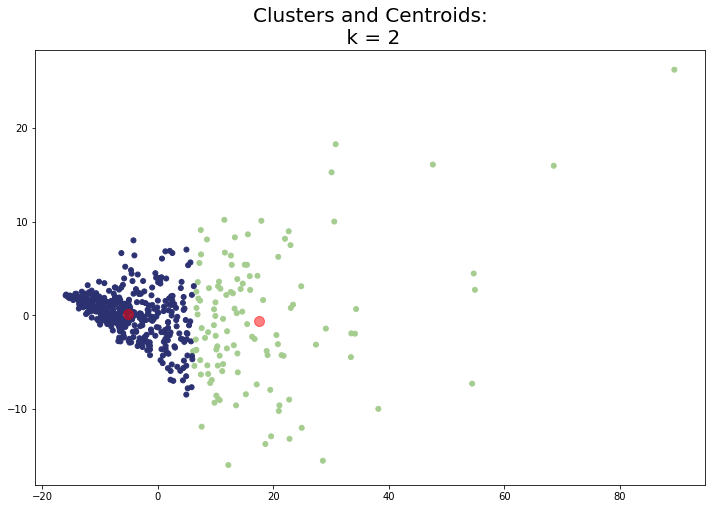

In [114]:
plot_k_clusters(2, X_pca_sc_c)

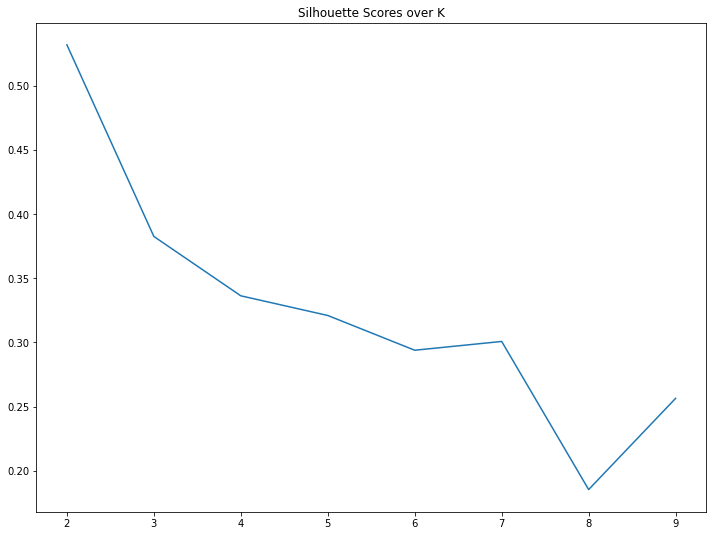

In [115]:
plot_sil_score(X_pca_c)

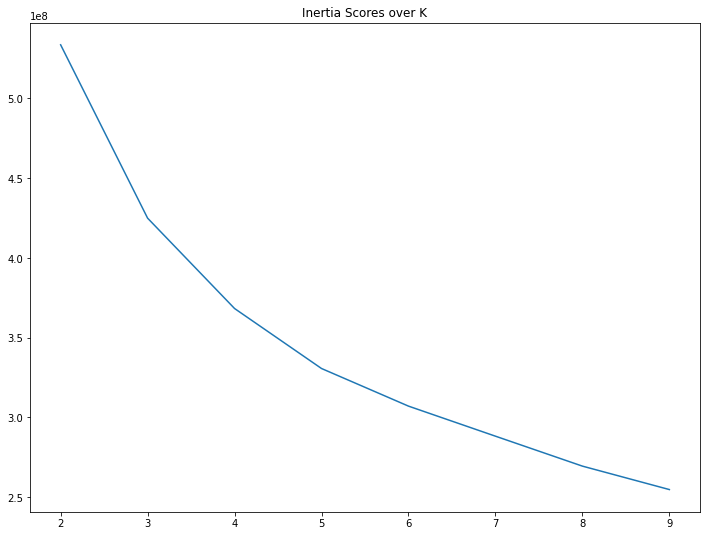

In [116]:
plot_inertia_score(X_pca_c)

In [117]:
find_scores_k(X_t)

,k,silhouette,inertia
0,2,0.100656,103.251343
1,3,0.113397,91.609348
2,4,0.112720,86.010648
3,5,0.105888,82.495022
4,6,0.075670,80.297979
5,7,0.085145,77.965513
6,8,0.072542,76.574277
7,9,0.064690,75.036474


In [118]:
find_scores_k(X_sc_t)

,k,silhouette,inertia
0,2,0.082584,95184.477319
1,3,0.068572,90225.852773
2,4,0.067750,87744.753491
3,5,0.047441,85624.980026
4,6,0.045860,83921.908585
5,7,0.029929,82771.696771
6,8,0.034963,82051.974972
7,9,0.033861,81032.299466


In [119]:
find_scores_k(X_pca_t)

,k,silhouette,inertia
0,2,0.108862,95.935613
1,3,0.120079,85.925148
2,4,0.119998,80.321300
3,5,0.111013,76.880516
4,6,0.091188,74.552201
5,7,0.084818,72.217517
6,8,0.073729,70.704845
7,9,0.073738,69.177789


In [120]:
find_scores_k(X_pca_sc_t)

,k,silhouette,inertia
0,2,0.087309,90039.930622
1,3,0.074550,85077.887144
2,4,0.059809,82674.676289
3,5,0.061046,80427.940153
4,6,0.044741,78940.502782
5,7,0.054832,77761.302237
6,8,0.036886,76771.502358
7,9,0.034341,75950.826617


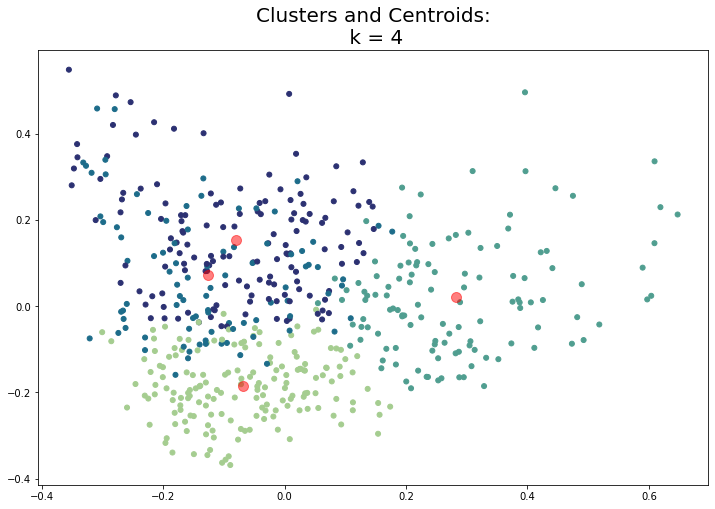

In [121]:
plot_k_clusters(4, X_pca_t)

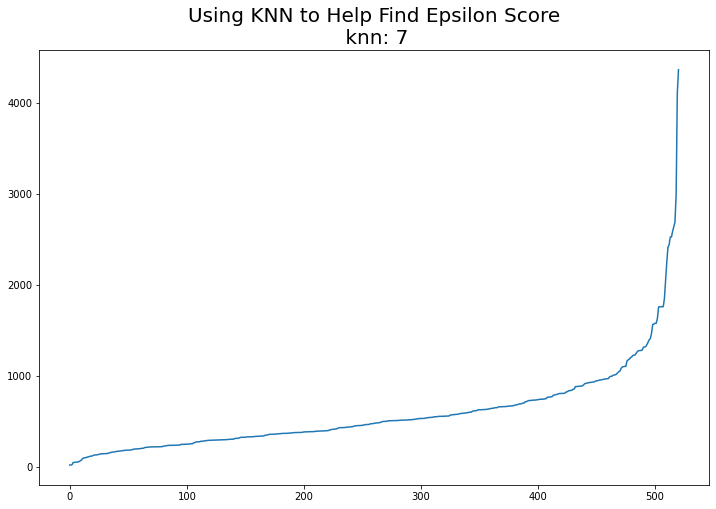

In [122]:
find_epsilon(X_c, 7)

In [123]:
find_scores_db(X_c, 1500)

{0, -1}
0.1058795426783544
--------------------
 0    498
-1     23
Name: dbscan_label, dtype: int64
--------------------


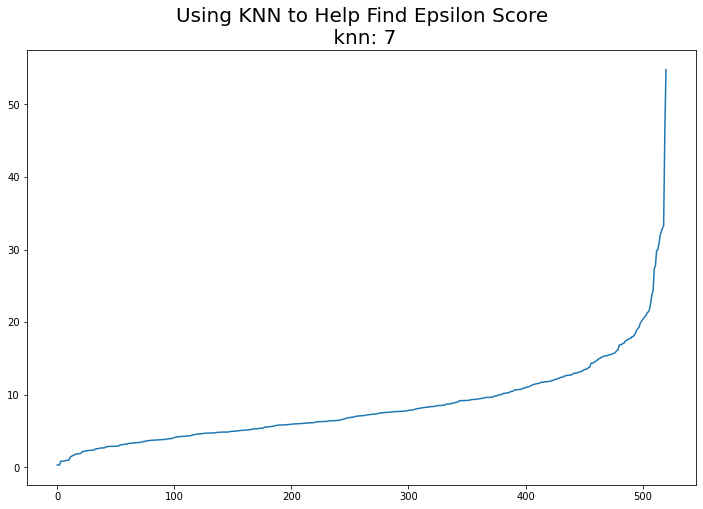

In [124]:
find_epsilon(X_sc_c, 7)

In [125]:
find_scores_db(X_sc_c, 18)

{0, -1}
0.07221193817913704
--------------------
 0    488
-1     33
Name: dbscan_label, dtype: int64
--------------------


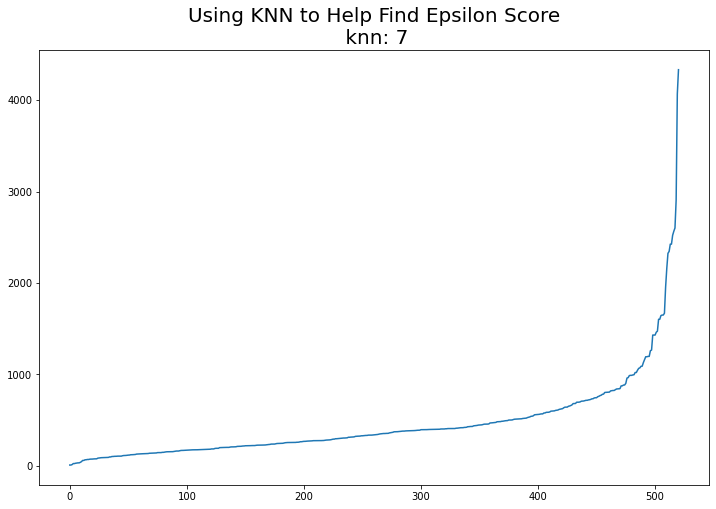

In [126]:
find_epsilon(X_pca_c, 7)

In [127]:
find_scores_db(X_pca_c, 1500)

{0, -1}
0.10382978628889457
--------------------
 0    502
-1     19
Name: dbscan_label, dtype: int64
--------------------


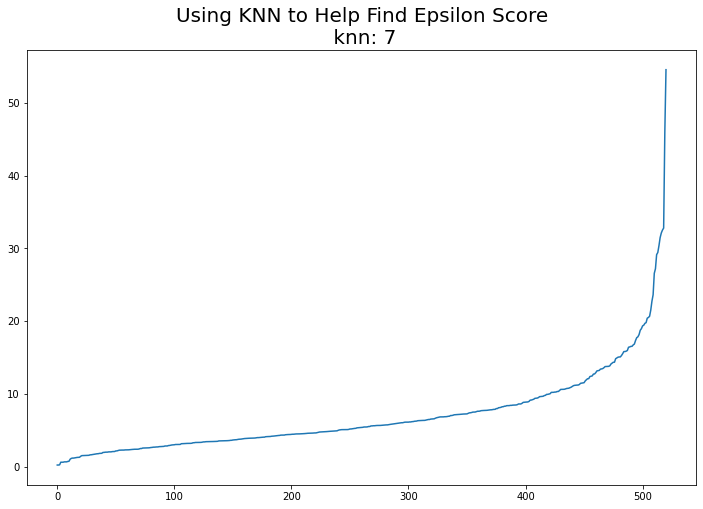

In [128]:
find_epsilon(X_pca_sc_c, 7)

In [129]:
find_scores_db(X_pca_sc_c, 18)

{0, -1}
0.07863437726599042
--------------------
 0    497
-1     24
Name: dbscan_label, dtype: int64
--------------------


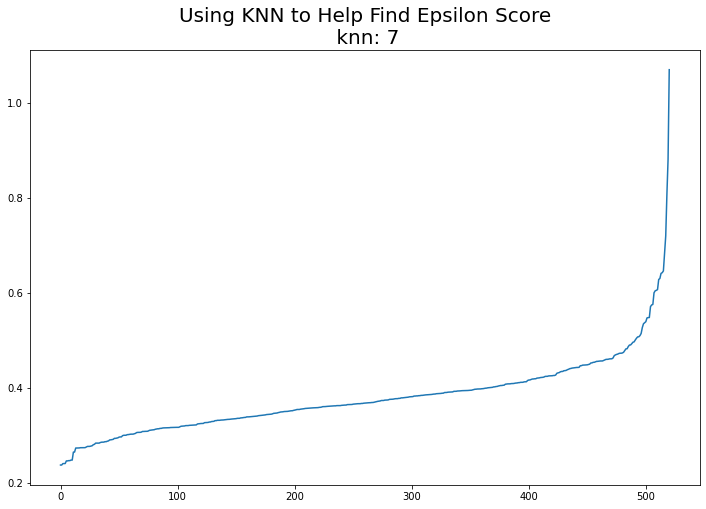

In [130]:
find_epsilon(X_t, 7)

In [131]:
find_scores_db(X_t, 0.5)

{0, -1}
0.219133436761535
--------------------
 0    490
-1     31
Name: dbscan_label, dtype: int64
--------------------


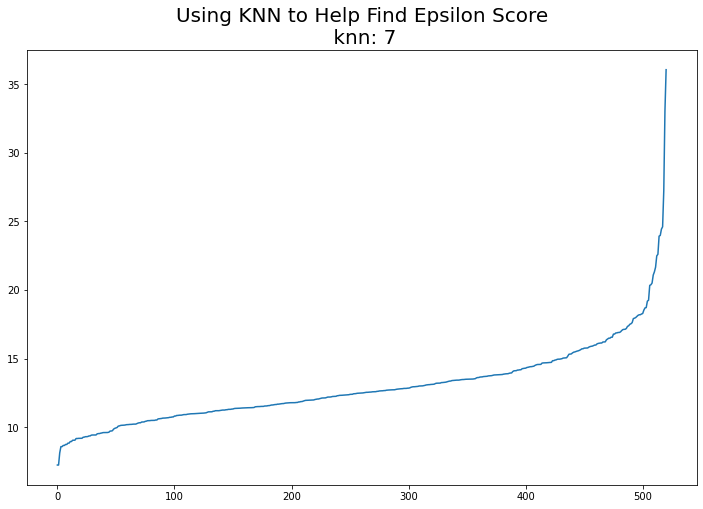

In [132]:
find_epsilon(X_sc_t, 7)

In [133]:
find_scores_db(X_sc_t, 18)

{0, -1}
0.22186572813248828
--------------------
 0    495
-1     26
Name: dbscan_label, dtype: int64
--------------------


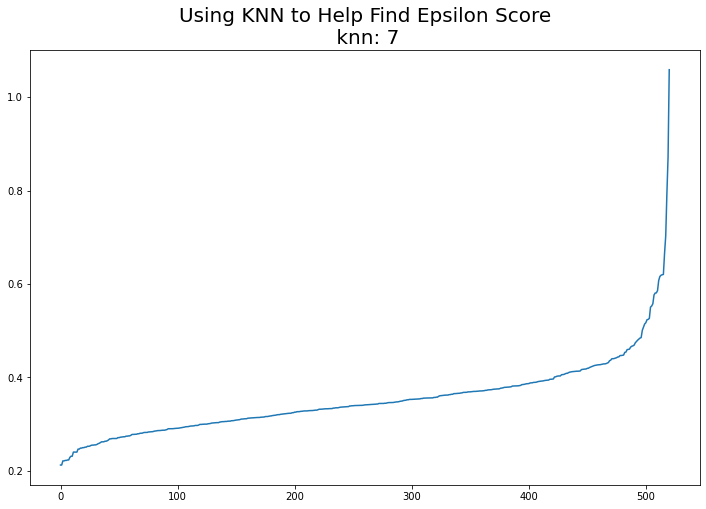

In [134]:
find_epsilon(X_pca_t, 7)

In [135]:
find_scores_db(X_pca_t, 0.45)

{0, -1}
0.19166157021549768
--------------------
 0    476
-1     45
Name: dbscan_label, dtype: int64
--------------------


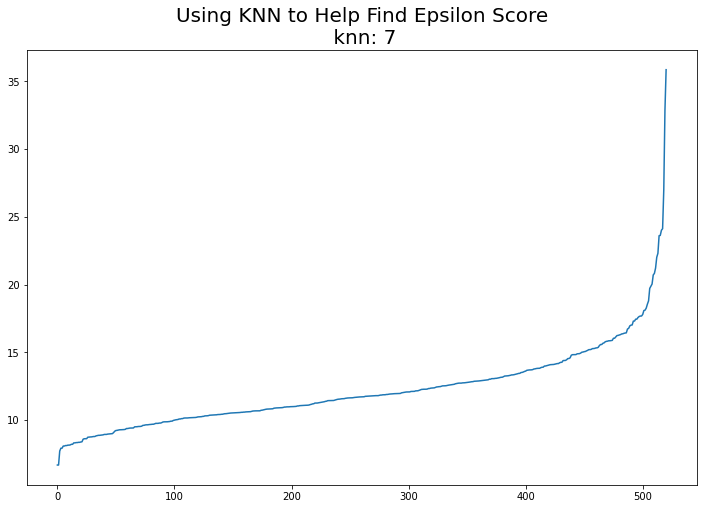

In [136]:
find_epsilon(X_pca_sc_t, 7)

In [137]:
find_scores_db(X_pca_sc_t, 17)

{0, -1}
0.1985690899593929
--------------------
 0    490
-1     31
Name: dbscan_label, dtype: int64
--------------------


In [138]:
# Get the cosine similarity for each document
# Help from Kelly Slatery
# Looking at the first 50 documents
vector_distances = pd.DataFrame(pairwise_distances(X_pca_c[:50], X_pca_c[:50], metric='cosine'))
vector_distances.corr().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.841398,0.415371,0.987701,0.754128,0.721095,0.727385,0.868534,0.893472,0.956334,0.804254,0.922322,0.876480,0.569628,0.474934,0.547684,0.958033,0.565280,0.884201,0.952370,-0.892680,0.479993,-0.523388,0.777106,0.097730,0.991498,0.503156,0.295516,-0.871125,0.302705,-0.908948,0.864048,-0.312107,0.690931,0.965877,0.384783,-0.871081,-0.370528,0.924580,-0.969753,-0.869126,0.670946,-0.915577,0.721218,-0.851758,0.946749,-0.798474,0.855287,-0.737015,-0.697844
1,0.841398,1.000000,-0.019424,0.817705,0.971872,0.322720,0.940742,0.907273,0.937532,0.904846,0.980338,0.948162,0.865216,0.886229,0.867399,0.789884,0.843891,0.882145,0.925612,0.756948,-0.957989,0.814232,-0.819526,0.975214,-0.150054,0.872644,0.581993,0.609704,-0.993255,0.748081,-0.942720,0.995749,-0.331843,0.267007,0.931280,-0.106078,-0.980750,0.151619,0.827335,-0.789585,-0.511425,0.624575,-0.975075,0.348851,-0.966253,0.922192,-0.805779,0.758331,-0.368807,-0.941830
2,0.415371,-0.019424,1.000000,0.489726,-0.226530,0.731120,-0.185915,-0.003816,0.145008,0.161120,-0.108893,0.129075,-0.004242,-0.434842,-0.407674,-0.213697,0.480357,-0.409965,0.235137,0.560067,-0.004036,-0.525122,0.494758,-0.180928,-0.006364,0.406815,0.275668,-0.154656,-0.028242,-0.631337,-0.221555,-0.003756,-0.359336,0.814526,0.220621,0.729405,0.033702,-0.840160,0.307342,-0.529089,-0.722710,0.303299,-0.072021,0.615669,0.075344,0.329975,-0.270017,0.350315,-0.449174,0.268785
3,0.987701,0.817705,0.489726,1.000000,0.709775,0.724933,0.688275,0.822522,0.868729,0.919602,0.770768,0.899285,0.822403,0.515224,0.446714,0.527888,0.972138,0.516692,0.880157,0.975706,-0.855824,0.418059,-0.470143,0.740093,0.037611,0.990196,0.525706,0.296631,-0.849672,0.245683,-0.909529,0.838499,-0.364651,0.727542,0.947200,0.409119,-0.836223,-0.408568,0.914596,-0.973645,-0.885270,0.656765,-0.889427,0.740412,-0.810541,0.951584,-0.811676,0.848471,-0.696925,-0.654522
4,0.754128,0.971872,-0.226530,0.709775,1.000000,0.192406,0.948977,0.900921,0.880138,0.875742,0.972613,0.906026,0.881411,0.951081,0.903408,0.798173,0.722435,0.937970,0.839712,0.638542,-0.950688,0.907120,-0.904925,0.991450,-0.088393,0.780150,0.459766,0.569285,-0.959291,0.844989,-0.867771,0.970297,-0.207242,0.124388,0.876966,-0.217354,-0.971359,0.294433,0.766506,-0.666308,-0.368649,0.527599,-0.945270,0.252278,-0.970220,0.831134,-0.726236,0.666856,-0.313697,-0.973143


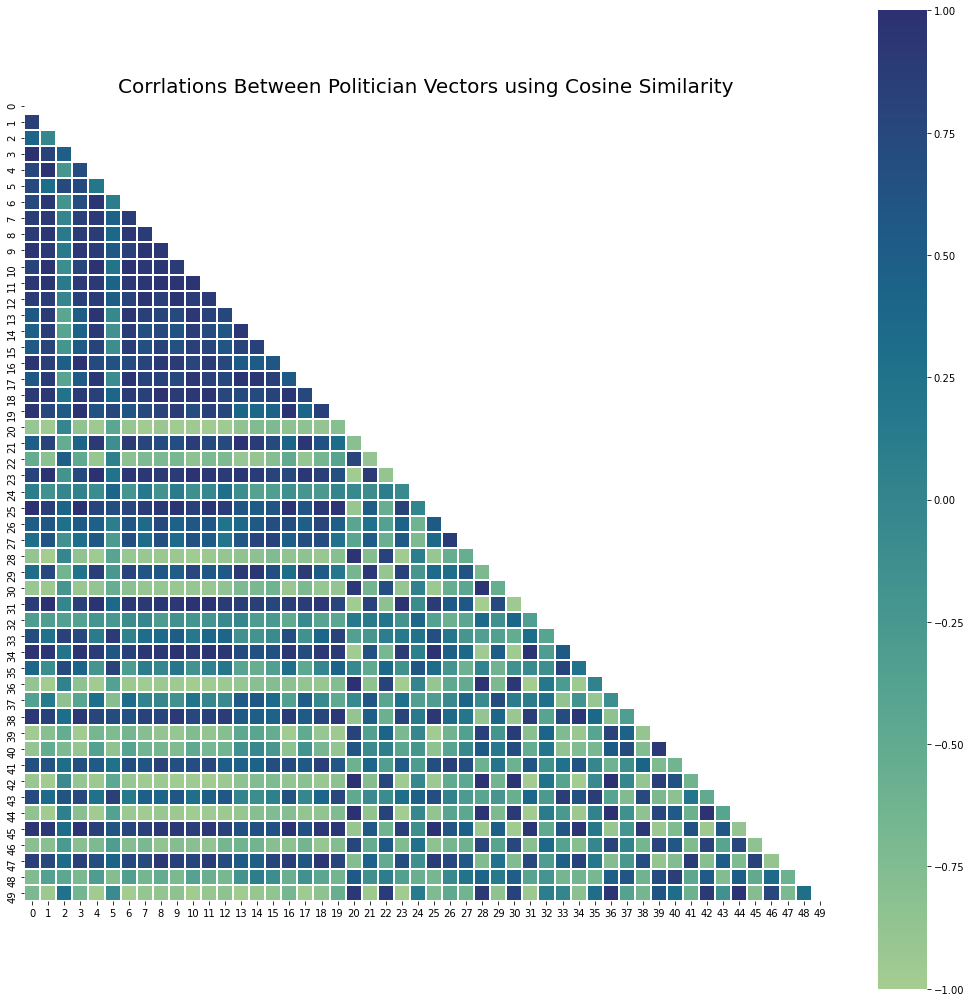

In [139]:
# Seeing correlations between first 50 documents (dataset is too large with all documents) using cosine similarity
plt.figure(figsize=(18,18))

corr = vector_distances.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
            cmap='crest', 
            vmax=1, 
            vmin=-1, 
            linecolor='white', 
            linewidths=1,
            square=True, 
           mask=mask)

plt.title('Corrlations Between Politician Vectors using Cosine Similarity', size=20)

plt.show()

In [145]:
# count the most frequently occuring words 

# dictionary to hold column header, count (key, value)
freq_words = {}

# loop through columns
for col in X_c.columns:
    
    # save sum of each column in dictionary
    freq_words[col] = X_c[col].sum()  
    
# save dictionary words in a dataframe
most_common = pd.DataFrame(sorted(freq_words.items(), key = lambda x: x[1], reverse = True))

most_common[:20]


,0,1
0,amp,267544
1,today,135032
2,work,128215
3,need,114571
4,trump,100076
5,help,99810
6,people,92380
7,act,91558
8,president,90792
9,thank,88556


In [140]:
# Attaching KM labels of 'best' model (highest silhouette score)
# to original dataframe 

km = KMeans(n_clusters=2, random_state=516)
km.fit(X_pca_sc_c)
km_means = km.predict(X_pca_sc_c)

print(set(km.labels_))

print(silhouette_score(X_pca_c, km.labels_))

print('--------------------')

data['km_label_cvec'] = km.labels_

print(data['km_label_cvec'].value_counts())

print('--------------------')


{0, 1}
0.5018627027308706
--------------------
1    404
0    117
Name: km_label_cvec, dtype: int64
--------------------


In [141]:

# # # Export dataframe with kmeans and dbscan labels
# # data.to_csv('./data/vectors_labels_df.csv', index=False)

# Exporting in google colab. Update directory as needed.
data.to_csv('/content/drive/MyDrive/Python/vectors_labels_df.csv', index=False)
